# Rapport de classification

Ce rapport détaille l'approche suivie pour la construction d'un modèle prédictif permettant d'estimer une caractéristique socio-économique des individus en France métropolitaine.


## 1. Introduction

Nous avons accès à un ensemble de données décrivant divers aspects socio-économiques des individus, répartis entre un ensemble d'apprentissage (train) et un ensemble de test. L'objectif est de construire un modèle permettant de prédire une variable cible en utilisant les autres variables disponibles.

## 2. Chargement des données

Nous devons d'abord charger les différentes sources de données et les assembler en une seule base exploitable.

In [1]:
%load_ext autoreload
%autoreload 2

In [193]:
from functools import reduce 
import numpy as np 
import pandas as pd 
import seaborn as sns

import phik
import matplotlib.pyplot as plt 
from src.tools import * 
from catboost import CatBoostClassifier, Pool 
import optuna
import optuna. visualization as vis
optuna.logging.set_verbosity(optuna.logging.WARNING)
import pygwalker as pyg 
import xgboost as xgb

from sklearn.metrics import accuracy_score

In [167]:
from src.tools import plot_loss

In [3]:
# Charger les datasets principaux
train_df = pd.read_csv("data/learn_dataset.csv")
emp_type_df = pd.read_csv("data/learn_dataset_emp_type.csv")
job_df = pd.read_csv("data/learn_dataset_job.csv")
retired_former_df = pd.read_csv("data/learn_dataset_retired_former.csv")
retired_jobs_df = pd.read_csv("data/learn_dataset_retired_jobs.csv")
retired_pension_df = pd.read_csv("data/learn_dataset_retired_pension.csv")
sport_df = pd.read_csv("data/learn_dataset_sport.csv")

city_adm_df = pd.read_csv("data/city_adm.csv")
city_pop_df = pd.read_csv("data/city_pop.csv")
code_sports_df = pd.read_csv("data/code_sports.csv")

dep_act_rate_df = pd.read_csv("add_data/dep_activity_rate.csv")
dep_median_inc_df = pd.read_csv("add_data/dep_median_income.csv")

In [63]:
def merge_add_dfs(df: pd. DataFrame) :
    df = df.merge(city_adm_df, on= 'INSEE', how='left')\
            .merge(city_pop_df, on='INSEE', how='left')\
            .merge(dep_median_inc_df, on='DEP', how='left')\
            .merge(sport_df, on='PRIMARY_KEY', how='left')\
            .merge(code_sports_df, left_on='sports', right_on= 'Code', how='left')
    try:
        df = df.merge (dep_act_rate_df, on='Job_dep', how='left') 
    finally:
        return df

active_subdf = job_df.merge(emp_type_df, on= 'PRIMARY_KEY', how='left')

retired_subdf = retired_jobs_df.merge(retired_former_df, on='PRIMARY_KEY', how='left')\
            .merge(retired_pension_df, on= 'PRIMARY_KEY', how= 'left' )

full_df = train_df.merge(pd.concat([active_subdf, retired_subdf]), on= 'PRIMARY_KEY', how= 'left')
full_df = merge_add_dfs(full_df)

active_df = train_df .merge(active_subdf, on= 'PRIMARY_KEY', how= 'inner') 
active_df = merge_add_dfs (active_df)

retired_df = train_df.merge (retired_subdf, on= 'PRIMARY_KEY', how='inner')
retired_df = merge_add_dfs (retired_df)

inactive_df = train_df [~train_df ['PRIMARY_KEY'].isin(active_df['PRIMARY_KEY']) &
                        ~train_df ['PRIMARY_KEY'].isin(retired_df['PRIMARY_KEY'])]
inactive_df = merge_add_dfs(inactive_df)

assert full_df.shape[0] == active_df.shape[0] + retired_df.shape[0] + inactive_df.shape[0]

full_df.to_csv('merged_csv/merged_dataset_full.csv', index=False)
active_df.to_csv('merged_csv/merged_dataset_job.csv', index=False)
retired_df.to_csv('merged_csv/merged_dataset_retired.csv', index=False)
inactive_df.to_csv ('merged_csv/merged_dataset_inactive.csv', index=False)

(full_df.shape, active_df.shape, retired_df.shape, inactive_df.shape)

((50042, 37), (19324, 32), (11189, 35), (19529, 20))

## 3. Exploration et nettoyage des données

Nous allons analyser la structure des données, détecter les valeurs manquantes et gérer les incohérences éventuelles.

In [5]:
def spit_job_desc(df):    
    return df.insert(df.columns.get_loc('job_desc') + 1, 'job_desc_n1', df['job_desc'].astype(str).str[0])

def num_to_cat(df_:pd.DataFrame, columns)->pd.DataFrame:
    df = df_.copy()
    for column in columns:
        if column in df.columns:
            deciles, bins = pd.qcut(df[column], q=10, labels=False, retbins=True, duplicates='drop')
            decile_labels = [f"{int(bins[i])}_to_{int(bins[i+1])}" for i in range(len(bins)-1)]

            df[column] = deciles.map(lambda d: decile_labels[int(d)] if pd.notnull(d) else d)
    return df

def transform_y(y:pd.Series):
    if y.name != 'target':
        raise ValueError("transform_y(y) y column is not 'target' ")
    return y.apply(lambda x : 0 if x == 'A' else 1)




In [69]:
full_df.columns

Index(['PRIMARY_KEY', 'INSEE', 'Household_type', 'JOB_42', 'Highest_degree',
       'Studying', 'AGE_2019', 'act', 'sex', 'target', 'Working_hours',
       'TYPE_OF_CONTRACT', 'company_category', 'Work_condition', 'ECO_SECT',
       'job_desc', 'employee_count', 'Job_dep', 'remuneration', 'job_category',
       'emp_type', 'LAST_DEP', 'LAST_JOB_42', 'last_emp_type',
       'retirement_age', 'Retirement_pay', 'Nom de la commune', 'town_type',
       'DEP', 'community_size', 'dep_median_inc', 'sports', 'Code',
       'Categorie', 'Nom fédération', 'Nom catégorie', 'dep_act_rate'],
      dtype='object')

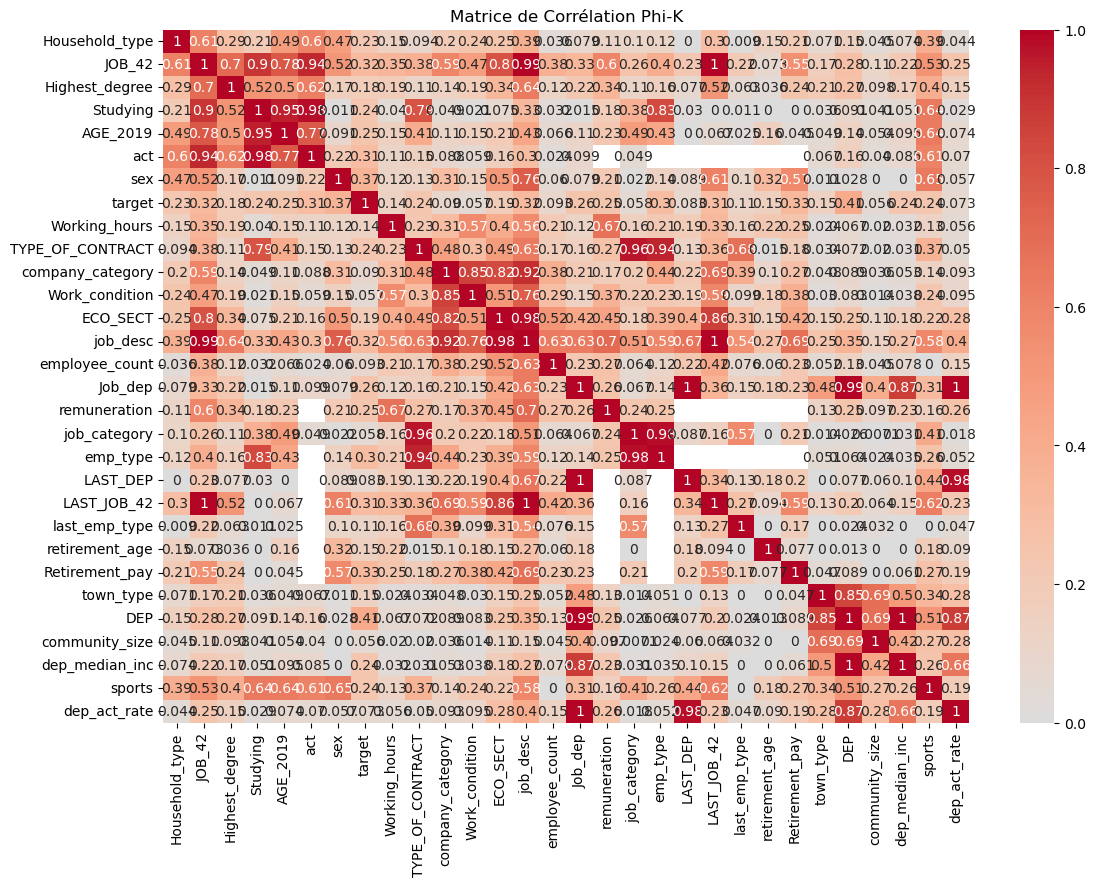

In [8]:

df_corr_matrix = num_to_cat (full_df, columns=['AGE_2019','Working_hours', 'remuneration',\
            'retirement_age', 'Retirement_pay', 'community_size', 'dep_median_inc', 'dep_act_rate'])
df_corr_matrix = df_corr_matrix.drop(columns= [ 'PRIMARY_KEY', 'INSEE', 'Nom de la commune',\
    'Code', 'Categorie', 'Nom fédération', 'Nom catégorie'])

corr_matrix = df_corr_matrix.phik_matrix()


plt.figure(figsize=(13, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matrice de Corrélation Phi-K")
plt.show()


## 4. Préparation des données

Nous devons convertir les variables catégoriques en valeurs numériques et traiter les valeurs manquantes.

In [38]:
active_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19324 entries, 0 to 19323
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PRIMARY_KEY        19324 non-null  int64  
 1   INSEE              19324 non-null  object 
 2   Household_type     19324 non-null  object 
 3   JOB_42             19324 non-null  object 
 4   Highest_degree     19324 non-null  object 
 5   Studying           19324 non-null  bool   
 6   AGE_2019           19324 non-null  int64  
 7   act                19324 non-null  object 
 8   sex                19324 non-null  object 
 9   target             19324 non-null  object 
 10  Working_hours      19312 non-null  float64
 11  TYPE_OF_CONTRACT   19324 non-null  object 
 12  company_category   18648 non-null  object 
 13  Work_condition     19324 non-null  object 
 14  ECO_SECT           19324 non-null  object 
 15  job_desc           19324 non-null  object 
 16  employee_count     187

In [55]:
active_df["Studying"].iloc[[1,30,103],].astype('int')

1      0
30     1
103    1
Name: Studying, dtype: int64

In [160]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder 
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split 

from enum import Enum
class Status(Enum):
    ACTIVE = "Active"
    INACTIVE = "Inactive"
    RETIRED = "Retired"

class DataPreprocessor:
    def __init__(self, init_df:pd.DataFrame, status:Status, OHE = True):
        self.df = init_df
        self.status = status
        
        self.numerical_features = []
        self.categorical_features = []
        self.target_feature = []
        
        self.OHE = OHE
        self.encoder_transformer = None
        self.target_encoder = None
        
        self.models = {}
        self.evals_results = {}
        # start process
        self.df = self.add_features(self.df)
        
        self.df = self.preprocess_columns(self.df)
        
        print("shape before OHE",self.df.shape)
        
        X_train, X_valid, y_train, y_valid = self.split_data(self.df)
        
        self.X_train = self.encoder_fit_transform(X_train)
        self.X_valid = self.encoder_transform(X_valid)
        
        print("shape x train",self.X_train.shape)
        
        self.y_train = self.target_encoder_fit_transform(y_train)
        self.y_valid = self.target_encoder_transform(y_valid)
        
        self.feature_names = self.get_feature_names()
        
        # self.X_train, self.y_train = self.remove _outliers (self.× train, self y_train) 
        if not OHE: # Catboost
            self.X_train = pd.DataFrame(self.X_train, columns=self.feature_names)
            self.X_valid = pd.DataFrame(self.X_valid, columns=self.feature_names)
            
    def preprocess_columns(self, df:pd.DataFrame, inference=False):
        df = df.drop(errors="ignore", columns= ['PRIMARY_KEY', 'INSEE', "job_desc",
                            "job_category", "TYPE_OF_CONTRACT", "ECO_SECT", "Nom de la commune",
                        "LAST_DEP", "sports", "Code", "Nom fédération", "Nom catégorie", "DEP"])
        
        if not inference:
            df["target"] = df["target"].astype('category')
            
        if self.status != Status.INACTIVE:
            df["Job_dep"] = df["Job_dep"].astype('object')
            
        df["Studying"] = df["Studying"].astype('int64')

        self.numerical_features = df.select_dtypes(['int64','float64']).columns.to_list()
        self.categorical_features = df.select_dtypes (['object']).columns.to_list()
        self.target_feature = "target"
        
        return df
        
        
    def add_features(self, df:pd.DataFrame): 
        if self.status != Status.INACTIVE:
            df["same_dep"] = df["Job_dep"] == df["DEP"]
            df["same_dep"] = df["same_dep"].astype('int64')
            
        return df
    
    def encoder_fit_transform(self, X):
        if  self.encoder_transformer is None:
            self.encoder_transformer = ColumnTransformer([
                ('num', Pipeline([
                    ('imputer', KNNImputer(n_neighbors=5)),
                    ('scaler', StandardScaler())
                ]), self.numerical_features),
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) \
                        if self.OHE else ('pass', 'passthrough')
                ]), self.categorical_features)
            ])
            print(self.status,'creating new encoder transformer')
        else:
            ValueError('encoder_transformer already exists')
        return self.encoder_transformer.fit_transform(X)
    
    def encoder_transform(self, X):
        return self.encoder_transformer.transform(X)
    
    def target_encoder_fit_transform(self, y):
        if self.target_encoder is None:
            self.target_encoder = LabelEncoder()
            print(self.status, 'creating new target encoder')
        else:
            ValueError('target _encoder already exists')
        return self.target_encoder.fit_transform(y)
    
    def target_encoder_transform(self, y):
        return self.target_encoder.transform(y)
    
    def target_encoder_inverse_transform(self, y) :
        return self.target_encoder.inverse_transform(y)
    
    def split_data(self, df:pd.DataFrame) :
        X = df.drop(columns=self.target_feature)
        y = df[self.target_feature]
        X_train, X_valid, y_train, y_valid = train_test_split (X, y, test_size=0.15, random_state=42, stratify=y, shuffle=True)
        return X_train, X_valid, y_train, y_valid
                                    
    def remove_outliers (self, X, y):
        iso_forest = IsolationForest (contamination="auto", random_state=42)
        outlier_preds = iso_forest.fit_predict(X)
        
        X_clean = X[outlier_preds == 1]
        y_clean = y[outlier_preds == 1]
        
        print(self.status, f"cleaning: {(1 - X_clean.shape[0]/ X.shape[0])*100:.4} % outliers") 
        return X_clean, y_clean
    
    def get_feature_names(self):
        feature_names = list(self.encoder_transformer.named_transformers_['cat'].named_steps['onehot']\
                            .get_feature_names_out(input_features=self.categorical_features))\
                                if self.OHE else self.categorical_features
        return self.numerical_features + feature_names

In [110]:
active = DataPreprocessor(active_df, Status.ACTIVE)
retired = DataPreprocessor(retired_df, Status.RETIRED)
inactive = DataPreprocessor(inactive_df, Status.INACTIVE)

shape before OHE (19324, 21)
Status.ACTIVE creating new encoder transformer
shape x train (15459, 187)
Status.ACTIVE creating new target encoder
shape before OHE (11189, 23)
Status.RETIRED creating new encoder transformer
shape x train (8951, 191)
Status.RETIRED creating new target encoder
shape before OHE (19529, 12)
Status.INACTIVE creating new encoder transformer
shape x train (15623, 80)
Status.INACTIVE creating new target encoder


In [70]:
pd.DataFrame(active.X_train, columns=active.feature_names)

,Studying,AGE_2019,Working_hours,remuneration,community_size,dep_median_inc,Categorie,dep_act_rate,same_dep,Household_type_TYPEMR|1|1,...,emp_type_EMP1.3,emp_type_EMP1.4,emp_type_EMP1.5,emp_type_EMP1.6,town_type_Capitale d'état,town_type_Chef-lieu canton,town_type_Commune simple,town_type_Préfecture,town_type_Préfecture de région,town_type_Sous-préfecture
0,-0.200249,-1.011637,0.912393,-0.143017,0.909232,-0.518806,-0.818294,-0.386870,0.576180,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.200249,-1.182608,0.976329,-0.048536,-0.289660,-0.275229,-0.270521,-0.171318,0.576180,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.200249,-0.156782,0.629243,1.466693,-0.500479,1.912759,1.920573,2.068019,-1.735569,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.200249,-0.071296,0.221874,0.890880,0.029801,-0.275229,-0.818294,-0.171318,0.576180,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.200249,0.698074,-1.537305,-1.011555,-0.569593,-0.913567,-0.818294,-1.464625,0.576180,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15454,-0.200249,0.612589,0.629243,0.026098,-0.523917,-0.182838,-0.270521,-1.237099,0.576180,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
15455,-0.200249,-0.755181,-0.125212,-0.424119,0.016968,2.580494,-0.270521,1.409390,-1.735569,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
15456,-0.200249,-0.242267,1.009211,-0.396618,-0.523604,-0.329824,-0.818294,-1.021548,0.576180,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
15457,-0.200249,0.270646,0.220047,0.394947,-0.521910,0.048140,-1.092181,0.152008,-1.735569,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [71]:
summarize_categoricals(active.df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values,% empty,type
Household_type,"[TYPEMR|4|1, TYPEMR|4|3, TYPEMR|1|2, TYPEMR|4|...",9,0,0.0,object
JOB_42,"[csp_5_4, csp_6_7, csp_5_3, csp_4_3, csp_5_5, ...",24,0,0.0,object
Highest_degree,"[dip|1|6, dip|1|3, dip|1|2, dip|1|7, dip|3, di...",12,0,0.0,object
Studying,"[0, 1]",2,0,0.0,int64
AGE_2019,"[46, 33, 24, 23, 43, 30, 59, 45, 56, 31, 53, 4...",61,0,0.0,int64
act,[ACT1.1],1,0,0.0,object
sex,"[Female, Male]",2,0,0.0,object
target,"['A', 'E'] Categories (2, object): ['A', 'E']",2,0,0.0,category
Working_hours,"[1935.0, 1697.0, nan, 1852.0, 1912.0, 1130.0, ...",2257,12,0.1,float64
company_category,"[ct_8, ct_9, ct_1, ct_3, ct_2, nan, ct_6, ct_7...",10,676,3.5,object


In [24]:
active_df.shape

(19324, 33)

In [23]:
active.X_train.shape

(15459, 6577)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

# stratkfold = KFold(n_splits=3, shuffle=True, random_state=42)
stratkfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid Search pour optimiser l'hyperparamètre "C" (régularisation)
glm_param_grid = {
    "solver": ['liblinear', 'lbfgs'],
    "penalty": ['l2'],
    "C": np.linspace(0.09, 0.5, num=3),
    "fit_intercept": [True, False],
    "class_weight": [None]
}

glm_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=1)

optimizer = GridSearchCV(glm_model, glm_param_grid, cv=stratkfold,
    refit="neg_root_mean_squared_error", scoring=['r2', 'neg_root_mean_squared_error'], n_jobs=-1, verbose=1
)

# optimizer = RandomizedSearchCV(glm_model, glm_param_grid, cv=stratkfold, n_iter=100, \
#                   scoring=['r2', 'neg_root_mean_squared_error'], n_jobs=-1, verbose=1)


for data_proc in [active, retired, inactive]:
    optimizer.fit(data_proc.X_train, data_proc.y_train)
    data_proc.models["ridge"] = optimizer.best_estimator_
    print(f"Meilleurs paramètres : {optimizer.best_params_}")


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Meilleurs paramètres : {'C': 0.29500000000000004, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'lbfgs'}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Meilleurs paramètres : {'C': 0.5, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'lbfgs'}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Meilleurs paramètres : {'C': 0.5, 'class_weight': None, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'lbfgs'}


In [ ]:

pd.DataFrame(optimizer.cv_results_).sort_values(by="rank_test_neg_root_mean_squared_error").transpose()


,4,5,6,7,1,0,2,3
mean_fit_time,9.22224,8.39978,6.208585,6.195654,3.441637,3.653753,2.925943,2.925906
std_fit_time,0.070264,0.120468,0.067955,0.065964,0.082111,0.062149,0.032785,0.042493
mean_score_time,0.153986,0.165738,0.200285,0.1817,0.159284,0.181065,0.156455,0.172471
std_score_time,0.004257,0.00138,0.005449,0.01211,0.003448,0.000829,0.004225,0.003973
param_model__learning_rate,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
param_model__max_depth,20,20,20,20,10,10,10,10
param_model__max_features,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt
param_model__min_samples_leaf,2,2,5,5,2,2,5,5
param_model__min_samples_split,5,10,5,10,10,5,5,10
param_model__n_estimators,100,100,100,100,100,100,100,100


### Démarche de tuning d'hyper parametres avez gridSearch :


A Chaques experiences, on rédige un jeu de paramètres à tester, et on déduit lesquels garder en fonction du CV_results.

Si le produit cartésient (l'ensemble de combinaison) des paramètres est trop grand, on réduit le nombre de folds pour accélerer l'algo.

On choisit le paramètre étudié avec le meilleur score+std (on veux que les résultats entres folds ne varient peu pour garder une généralisation)

-> Process :

1. On commence par mettre tous les paramètres interessant et leurs des valeurs coherentes en vue du contexte. (Solver, pénalité, intercept, classes balancées...)

 - on execute un randomized, pour equarter les configurations evidantes.
 - on affine et décide de quels parametres garder

2. Pour les paramètres "importants" ici C, on effectue un GridSearch avec un jeu de paremètres restreits
   
 - sur des bornes larges, puis de plus en plus sérées



### Rapport de classification [Status.ACTIVE] : 
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      2156
           1       0.75      0.73      0.74      1709

    accuracy                           0.78      3865
   macro avg       0.77      0.77      0.77      3865
weighted avg       0.78      0.78      0.78      3865



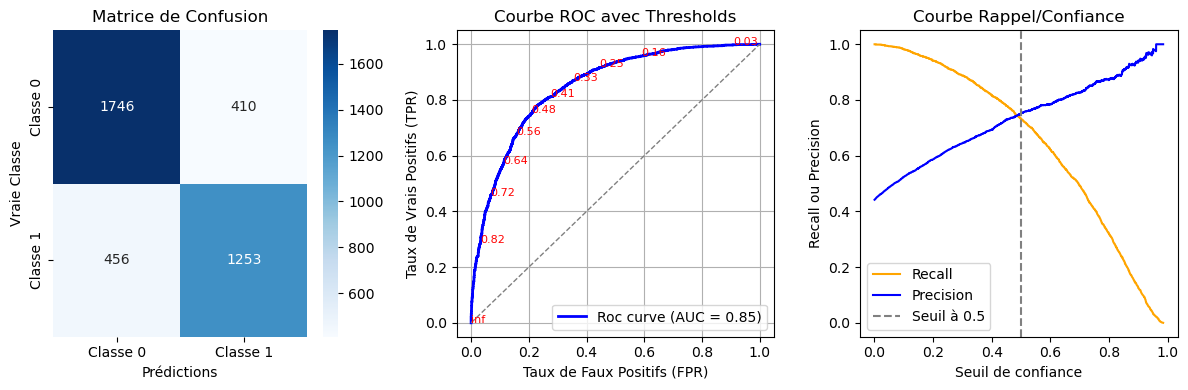

### Rapport de classification [Status.RETIRED] : 
               precision    recall  f1-score   support

           0       0.80      0.83      0.82      1330
           1       0.74      0.69      0.71       908

    accuracy                           0.78      2238
   macro avg       0.77      0.76      0.77      2238
weighted avg       0.77      0.78      0.77      2238



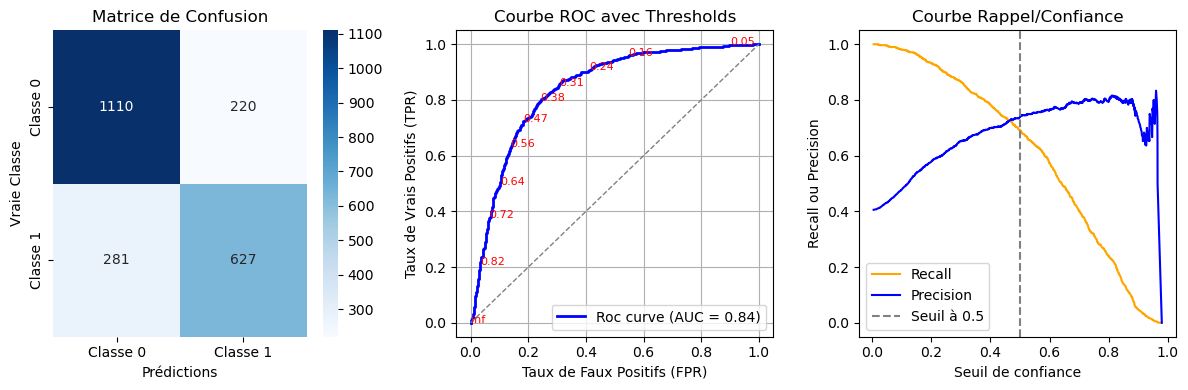

### Rapport de classification [Status.INACTIVE] : 
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      2870
           1       0.67      0.47      0.56      1036

    accuracy                           0.80      3906
   macro avg       0.75      0.70      0.71      3906
weighted avg       0.79      0.80      0.79      3906



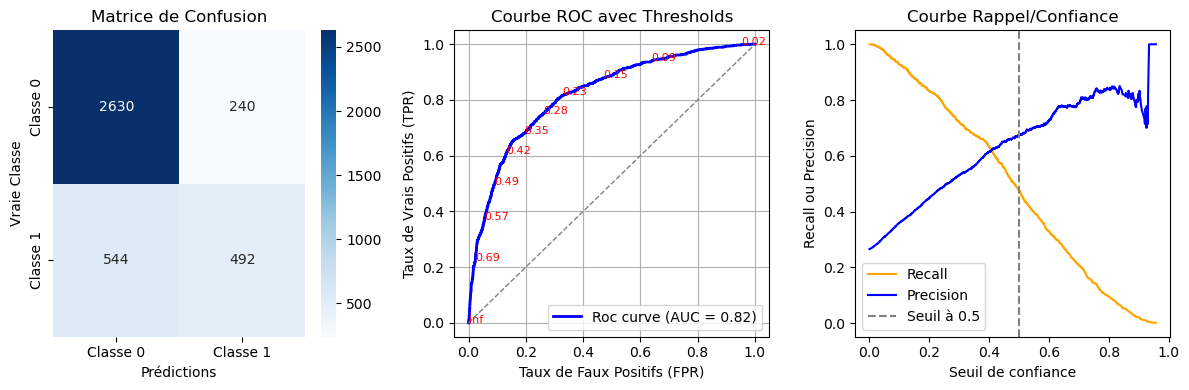

In [12]:
for data_proc in [active, retired, inactive]:
    evaluate_model(data_proc, "ridge")

### Rapport de classification [All data_procs] : 
               precision    recall  f1-score   support

           0       0.81      0.86      0.84      6356
           1       0.73      0.65      0.69      3653

    accuracy                           0.79     10009
   macro avg       0.77      0.76      0.76     10009
weighted avg       0.78      0.79      0.78     10009



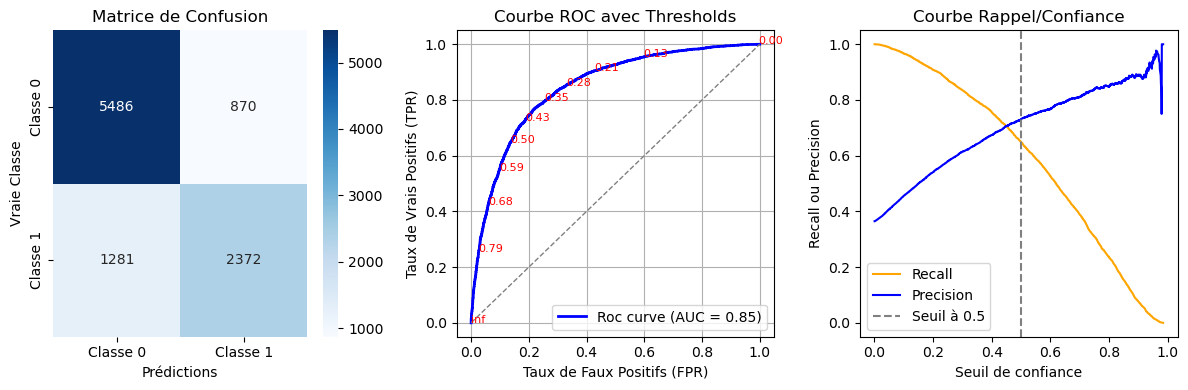

In [13]:
evaluate_multi_model([active, retired, inactive], "ridge")

# Random Forests

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

stratkfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_param_grid = {
    'n_estimators': [200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2],
    'max_features': ['log2', 'sqrt'],
    'bootstrap': [True],
    'criterion': ['gini'],
    'class_weight': ['balanced', 'balanced_subsample']
}

rf_model = RandomForestClassifier(random_state=42)

optimizer = GridSearchCV(
    rf_model, rf_param_grid, cv=stratkfold, refit='r2',
    scoring=['r2', 'neg_root_mean_squared_error'],
    n_jobs=-1, verbose=1
)

# optimizer = RandomizedSearchCV(rf_model, rf_param_grid, cv=stratkfold, n_iter=100,
# refit='neg_root_mean_squared_error', scoring=['r2', 'neg_root_mean_squared_error'], n_jobs=-1, verbose=1)

for data_proc in [active, retired, inactive]:
    optimizer.fit(data_proc.X_train, data_proc.y_train)
    data_proc.models["random_forest"] = optimizer.best_estimator_
    print(f"Meilleurs paramètres : {optimizer.best_params_}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Meilleurs paramètres : {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Meilleurs paramètres : {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Meilleurs paramètres : {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


### Rapport de classification [Status.ACTIVE] : 
               precision    recall  f1-score   support

           0       0.81      0.77      0.79      2156
           1       0.73      0.78      0.75      1709

    accuracy                           0.77      3865
   macro avg       0.77      0.77      0.77      3865
weighted avg       0.78      0.77      0.77      3865



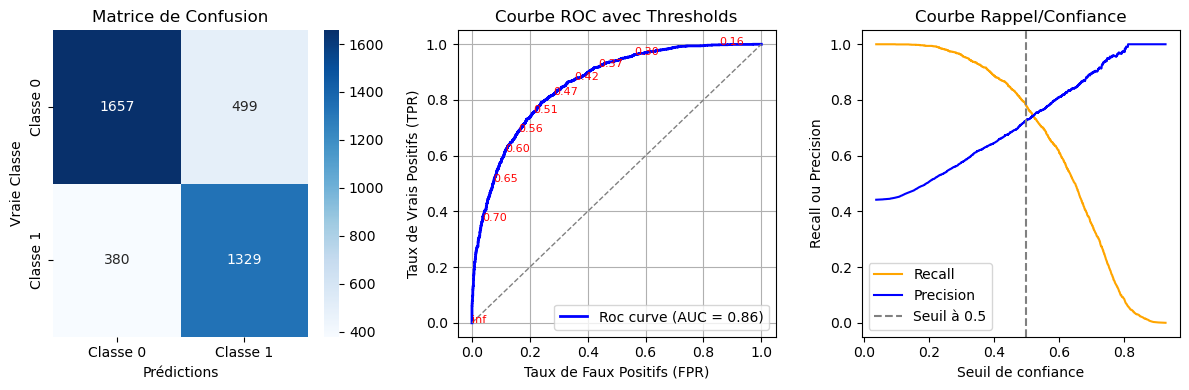

### Rapport de classification [Status.RETIRED] : 
               precision    recall  f1-score   support

           0       0.83      0.82      0.83      1330
           1       0.74      0.75      0.75       908

    accuracy                           0.79      2238
   macro avg       0.78      0.79      0.79      2238
weighted avg       0.79      0.79      0.79      2238



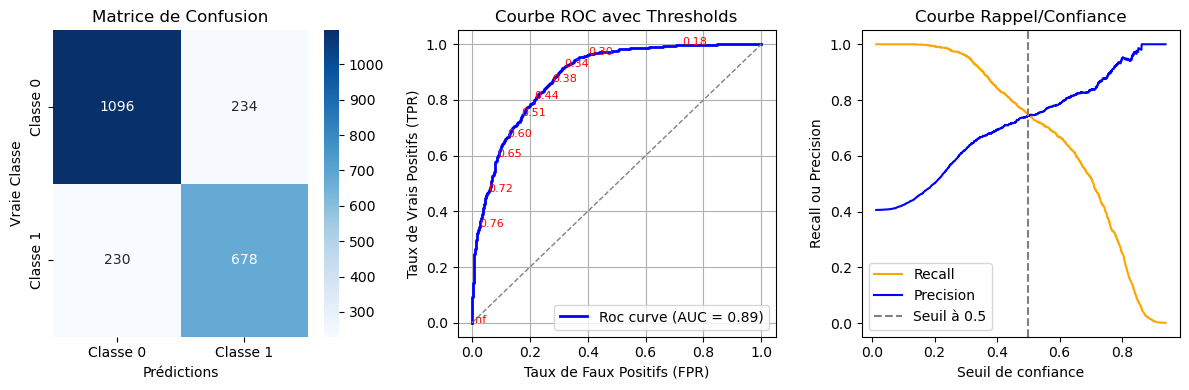

### Rapport de classification [Status.INACTIVE] : 
               precision    recall  f1-score   support

           0       0.90      0.85      0.88      2870
           1       0.65      0.74      0.69      1036

    accuracy                           0.82      3906
   macro avg       0.77      0.80      0.78      3906
weighted avg       0.83      0.82      0.83      3906



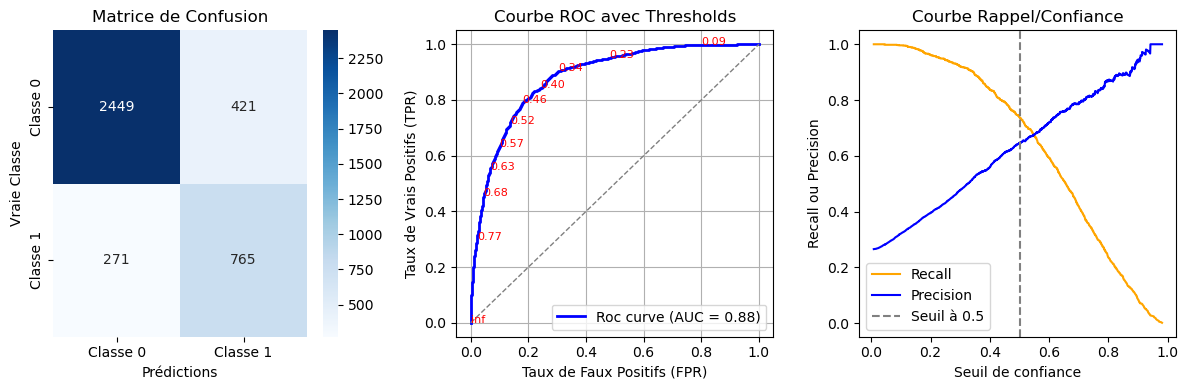

In [15]:
for data_proc in [active, retired, inactive]:
    evaluate_model(data_proc, "random_forest")

### Rapport de classification [All data_procs] : 
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      6356
           1       0.71      0.76      0.73      3653

    accuracy                           0.80     10009
   macro avg       0.78      0.79      0.78     10009
weighted avg       0.80      0.80      0.80     10009



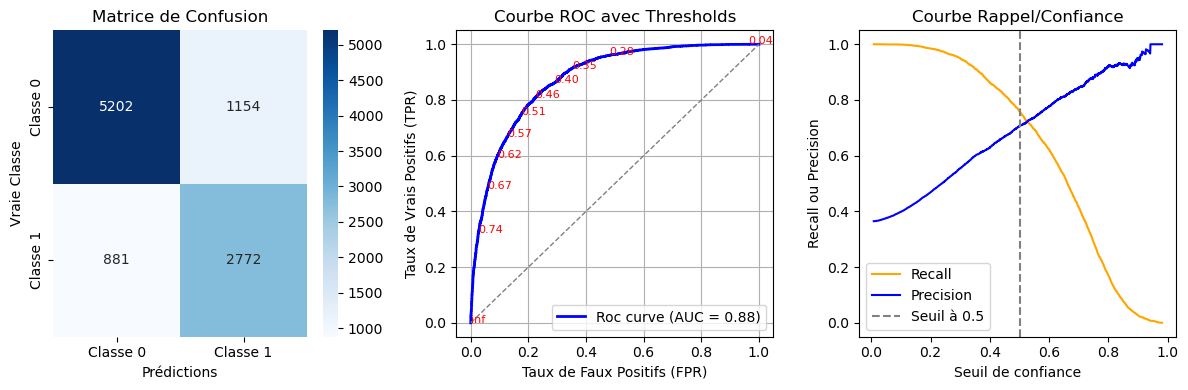

In [16]:
evaluate_multi_model([active, retired, inactive], "random_forest")

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, GridSearchCV

stratkfold = KFold(n_splits=3, shuffle=True, random_state=42)

mlp_param_grid = {
    'hidden_layer_sizes': [(200, 50, 5), (100, 50, 5)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam'],
    'alpha': [0.01, 0.001],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [100],
    'batch_size': [128],
    'early_stopping': [True]
}

mlp_model = MLPClassifier(random_state=42)

optimizer = GridSearchCV(
    mlp_model, mlp_param_grid, cv=stratkfold, refit='r2',
    scoring=['r2', 'neg_root_mean_squared_error'],
    n_jobs=-1, verbose=1
)

# optimizer = RandomizedSearchCV(mlp_model, mlp_param_grid, cv=stratkfold, n_iter=50,
# refit='neg_root_mean_squared_error', scoring=['r2', 'neg_root_mean_squared_error'], n_jobs=-1, verbose=1)

for data_proc in [active, retired, inactive]:
    optimizer.fit(data_proc.X_train, data_proc.y_train)
    data_proc.models["mlp"] = optimizer.best_estimator_
    print(f"Meilleurs paramètres : {optimizer.best_params_}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs paramètres : {'activation': 'tanh', 'alpha': 0.001, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (100, 50, 5), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs paramètres : {'activation': 'relu', 'alpha': 0.001, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (200, 50, 5), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Meilleurs paramètres : {'activation': 'relu', 'alpha': 0.001, 'batch_size': 128, 'early_stopping': True, 'hidden_layer_sizes': (100, 50, 5), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'adam'}


### Rapport de classification [Status.ACTIVE] : 
               precision    recall  f1-score   support

           0       0.83      0.84      0.83      2156
           1       0.79      0.79      0.79      1709

    accuracy                           0.82      3865
   macro avg       0.81      0.81      0.81      3865
weighted avg       0.81      0.82      0.81      3865



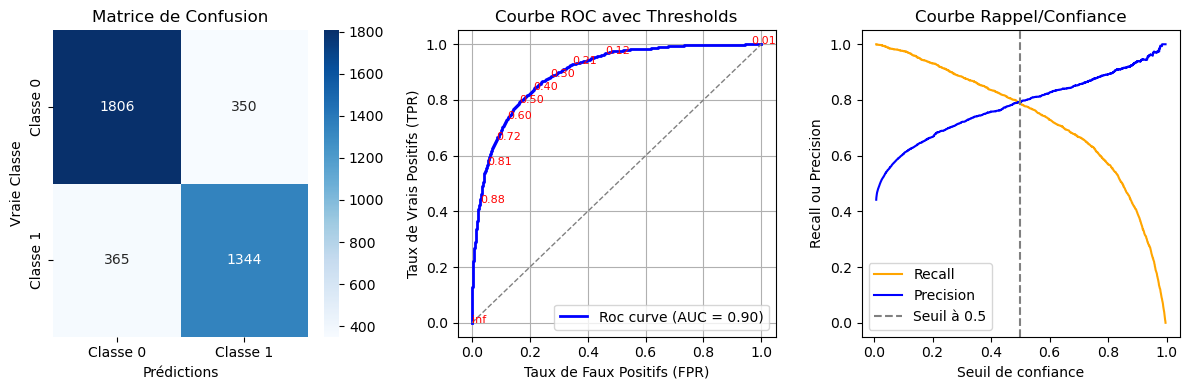

### Rapport de classification [Status.RETIRED] : 
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1330
           1       0.74      0.74      0.74       908

    accuracy                           0.79      2238
   macro avg       0.78      0.78      0.78      2238
weighted avg       0.79      0.79      0.79      2238



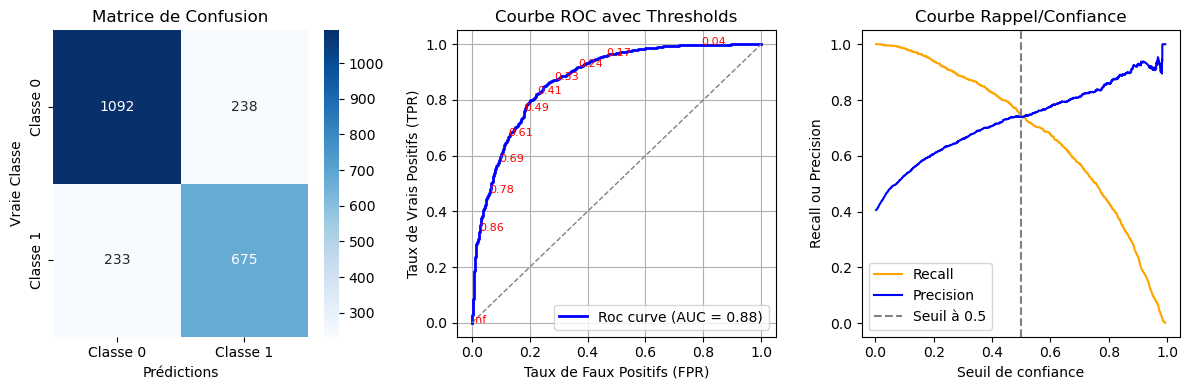

### Rapport de classification [Status.INACTIVE] : 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      2870
           1       0.68      0.64      0.66      1036

    accuracy                           0.82      3906
   macro avg       0.78      0.77      0.77      3906
weighted avg       0.82      0.82      0.82      3906



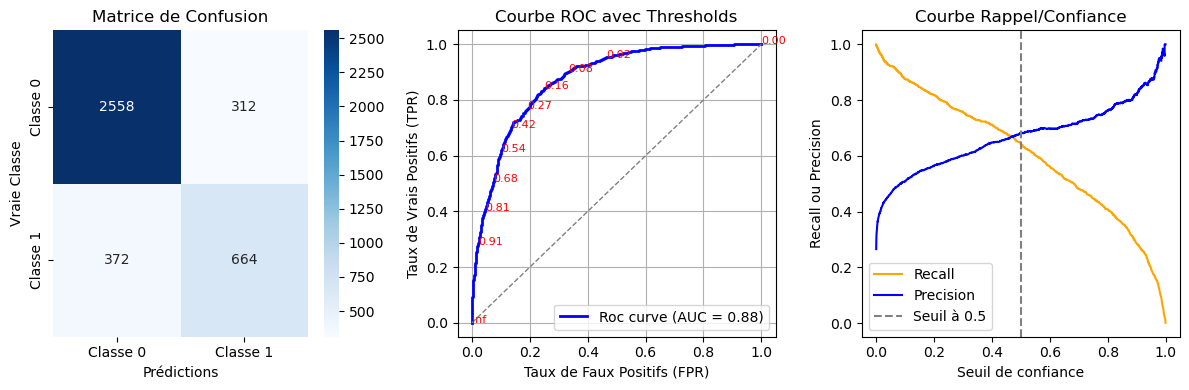

In [20]:
for data_proc in [active, retired, inactive]:
    evaluate_model(data_proc, "mlp")

### Rapport de classification [All data_procs] : 
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      6356
           1       0.75      0.73      0.74      3653

    accuracy                           0.81     10009
   macro avg       0.80      0.80      0.80     10009
weighted avg       0.81      0.81      0.81     10009



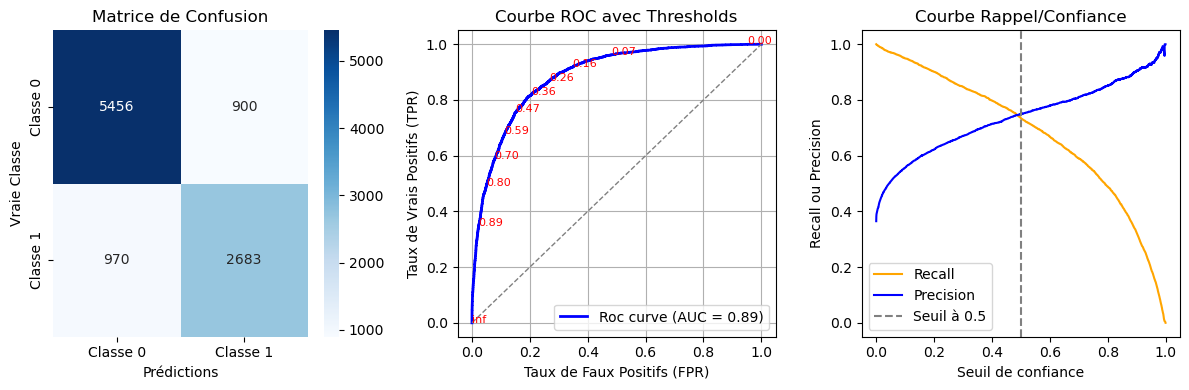

In [21]:
evaluate_multi_model([active, retired, inactive], "mlp")

# Modèle de boosting avec librairies

# CatBoost

In [113]:
active_cb = DataPreprocessor(active_df, Status.ACTIVE, OHE=False)
retired_cb = DataPreprocessor(retired_df, Status.RETIRED, OHE=False)
inactive_cb = DataPreprocessor(inactive_df, Status.INACTIVE, OHE=False)

shape before OHE (19324, 21)
Status.ACTIVE creating new encoder transformer
shape x train (15459, 20)
Status.ACTIVE creating new target encoder
shape before OHE (11189, 23)
Status.RETIRED creating new encoder transformer
shape x train (8951, 22)
Status.RETIRED creating new target encoder
shape before OHE (19529, 12)
Status.INACTIVE creating new encoder transformer
shape x train (15623, 11)
Status.INACTIVE creating new target encoder


In [174]:


for data_proc in [active_cb, retired_cb, inactive_cb]:
    assert data_proc.OHE == False

    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 20, 150),
            'depth': trial.suggest_int('depth', 3, 16),
            'learning_rate': trial.suggest_float('learning_rate', 1e-2, 1e-1, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 1.0, log=True),
            'border_count': trial.suggest_int('border_count', 32, 100),
            'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 10.0),
            'cat_features': data_proc.categorical_features,
            'eval_metric': 'Accuracy',
            'random_seed': 42,
            'verbose': 0
        }

        train_pool = Pool(data_proc.X_train, data_proc.y_train, cat_features=data_proc.categorical_features)
        test_pool = Pool(data_proc.X_valid, data_proc.y_valid, cat_features=data_proc.categorical_features)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=15)

        preds = model.predict(data_proc.X_valid)
        accuracy = accuracy_score(data_proc.y_valid, preds)
        return accuracy

    print(f"[{data_proc.status}]")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=15, show_progress_bar=True, n_jobs=3)

    print("Meilleurs hyperparamètres :", study.best_params)
    print("Meilleure accuracy :", study.best_value)
    display(vis.plot_param_importances(study))
    display(vis.plot_optimization_history(study))

    print(f"Training model ({data_proc.status}) on best params, with 1k iterations...")
    best_params = study.best_params
    best_params["iterations"] = 500

    best_model_cb = CatBoostClassifier(**best_params)
    train_pool = Pool(data_proc.X_train, data_proc.y_train, cat_features=data_proc.categorical_features)
    test_pool = Pool(data_proc.X_valid, data_proc.y_valid, cat_features=data_proc.categorical_features)
    best_model_cb.fit(train_pool, eval_set=test_pool, early_stopping_rounds=25, verbose=0)
    data_proc.models["catboost"] = best_model_cb
    data_proc.evals_results["catboost"] = best_model_cb.get_evals_result()


[Status.ACTIVE]


  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

# ...


### Rapport de classification [Status.ACTIVE] : 
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      2156
           1       0.82      0.81      0.82      1709

    accuracy                           0.84      3865
   macro avg       0.84      0.84      0.84      3865
weighted avg       0.84      0.84      0.84      3865



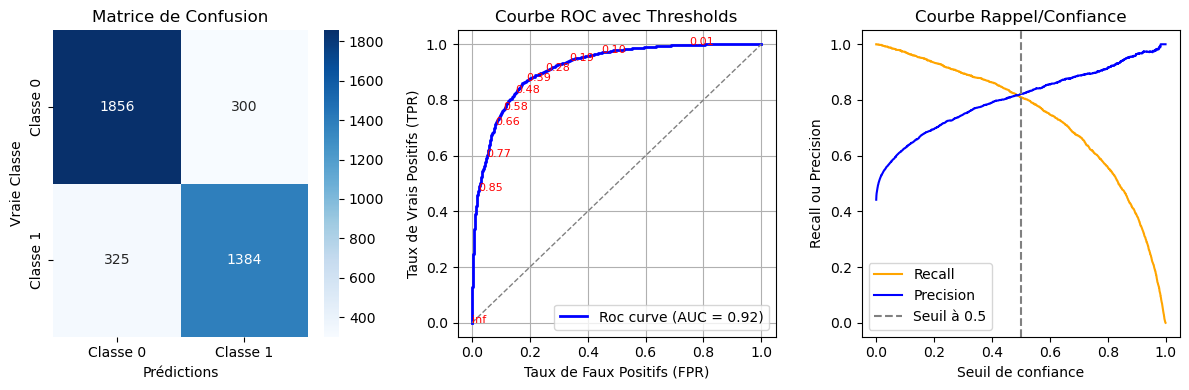

### Rapport de classification [Status.RETIRED] : 
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1330
           1       0.83      0.83      0.83       908

    accuracy                           0.87      2238
   macro avg       0.86      0.86      0.86      2238
weighted avg       0.87      0.87      0.87      2238



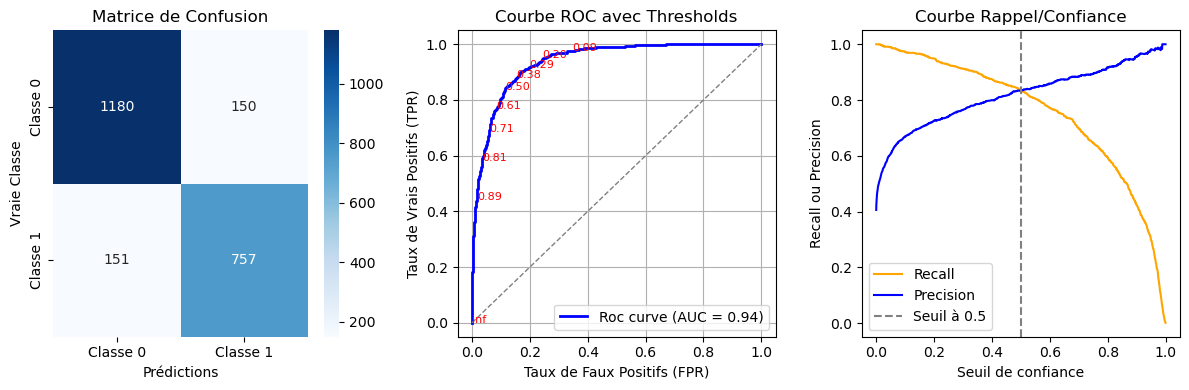

### Rapport de classification [Status.INACTIVE] : 
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      2870
           1       0.73      0.57      0.64      1036

    accuracy                           0.83      3906
   macro avg       0.79      0.75      0.76      3906
weighted avg       0.82      0.83      0.82      3906



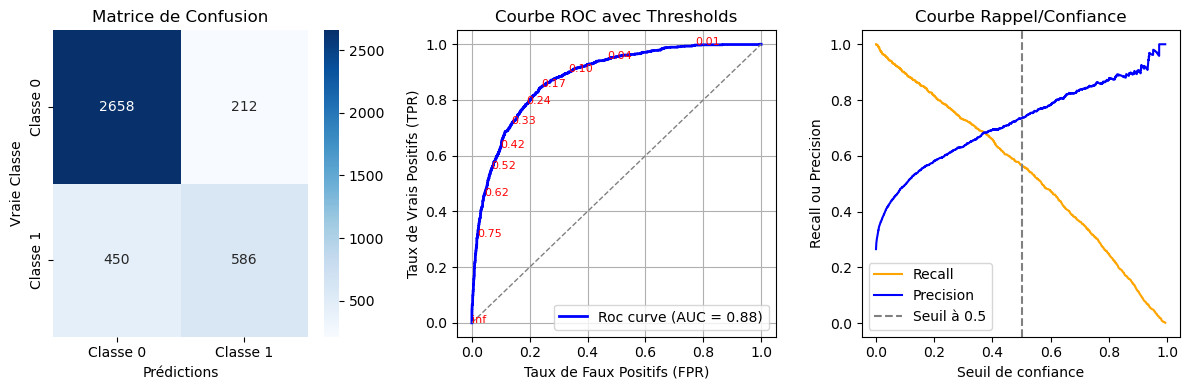

In [54]:
for data_proc in [active_cb, retired_cb, inactive_cb]:
    evaluate_model(data_proc, "catboost")

### Rapport de classification [All data_procs] : 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      6356
           1       0.80      0.75      0.77      3653

    accuracy                           0.84     10009
   macro avg       0.83      0.82      0.83     10009
weighted avg       0.84      0.84      0.84     10009



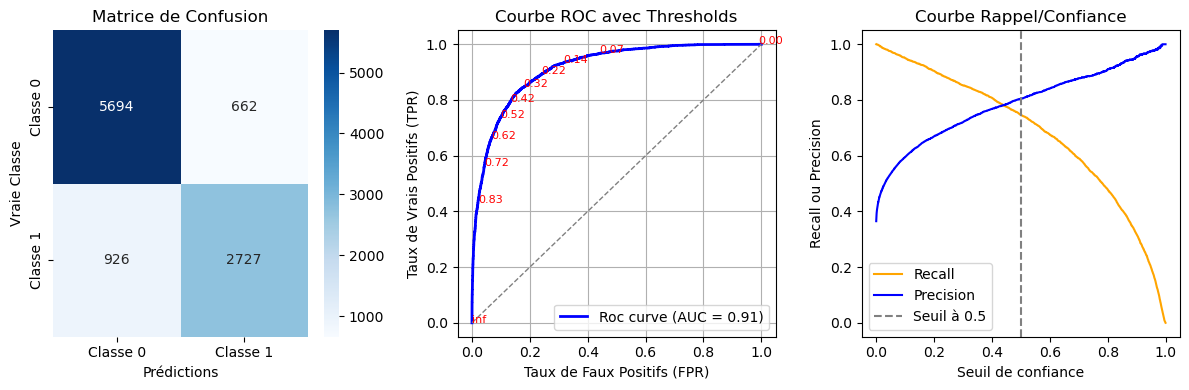

In [55]:
evaluate_multi_model([active_cb, retired_cb, inactive_cb], "catboost")

KeyError: 'catboost'

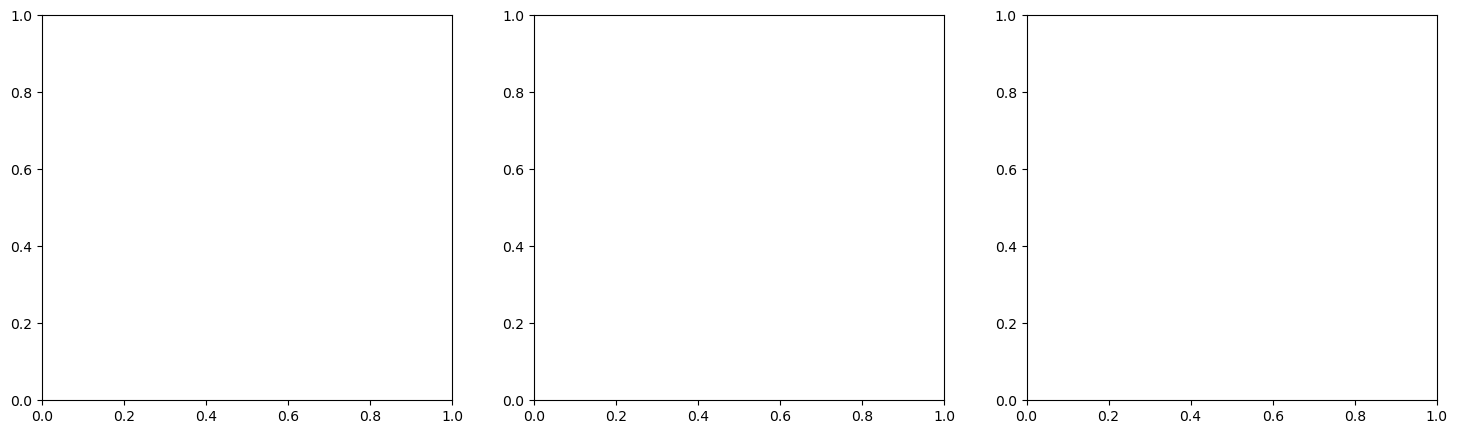

In [171]:
plot_loss([active_cb, retired_cb, inactive_cb], "catboost")

In [ ]:

import xgboost as xgb
from sklearn.metrics import accuracy_score
import optuna
import optuna.visualization as vis

for data_proc in [active, retired, inactive]:
    assert data_proc.OHE == True
    best_model = None

    dtrain = xgb.DMatrix(data_proc.X_train, label=data_proc.y_train)
    dvalid = xgb.DMatrix(data_proc.X_valid, label=data_proc.y_valid)

    def objective(trial):
        params = {
            "verbosity": 0,
            "objective": trial.suggest_categorical("objective",["binary:logistic"]),
            "booster": trial.suggest_categorical("booster",["gbtree"]),
            "eval_metric": trial.suggest_categorical("eval_metric",["logloss"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            "subsample": trial.suggest_float("subsample", 0.2, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            "max_depth": trial.suggest_int("max_depth", 3, 15, step=2),
            "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
            "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
            "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        }

        model = xgb.train(params, dtrain, evals=[(dvalid, 'validation')], num_boost_round=500,
                          early_stopping_rounds=50, verbose_eval=False)

        preds = model.predict(dvalid)
        preds_binary = (preds > 0.5).astype(int)
        accuracy = accuracy_score(data_proc.y_valid, preds_binary)
        return accuracy

    print(f"[[ {data_proc.status} ]]")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10, show_progress_bar=True, n_jobs=3)

    print("Meilleurs hyperparamètres :", study.best_params)
    print("Meilleure accuracy :", study.best_value)
    display(vis.plot_param_importances(study))
    display(vis.plot_optimization_history(study))

    print(f"Training model [{data_proc.status}] on best_params with 1000 iterations")
    best_params = study.best_params
    
    evals_result = {}
    best_model = xgb.train(best_params, dtrain, evals=[(dtrain, 'train'), (dvalid, 'validation')], num_boost_round=1000,
                           early_stopping_rounds=25, evals_result=evals_result, verbose_eval=False)

    data_proc.models["xgboost"] = best_model
    data_proc.evals_results["xgboost"] = evals_result
    


[[ Status.ACTIVE ]]


  0%|          | 0/10 [00:00<?, ?it/s]

Meilleurs hyperparamètres : {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'logloss', 'lambda': 6.099587674543576e-08, 'alpha': 5.083318605564828e-08, 'subsample': 0.6962244620133795, 'colsample_bytree': 0.8438124055102671, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.06571463525426131, 'gamma': 5.175646924154233e-05, 'grow_policy': 'lossguide'}
Meilleure accuracy : 0.8305304010349288


Training model [Status.ACTIVE] on best_params with 1000 iterations
[[ Status.RETIRED ]]


  0%|          | 0/10 [00:00<?, ?it/s]

Meilleurs hyperparamètres : {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'logloss', 'lambda': 0.0005478952043587649, 'alpha': 6.727078192803938e-07, 'subsample': 0.8351378967795915, 'colsample_bytree': 0.5836507748714113, 'max_depth': 15, 'min_child_weight': 5, 'eta': 0.09179781084861516, 'gamma': 0.18537520279462524, 'grow_policy': 'lossguide'}
Meilleure accuracy : 0.8534405719392315


Training model [Status.RETIRED] on best_params with 1000 iterations
[[ Status.INACTIVE ]]


  0%|          | 0/10 [00:00<?, ?it/s]

Meilleurs hyperparamètres : {'objective': 'binary:logistic', 'booster': 'gbtree', 'eval_metric': 'logloss', 'lambda': 6.672861435228365e-07, 'alpha': 0.0008666965063798841, 'subsample': 0.6769029193967235, 'colsample_bytree': 0.94224239678834, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.26702364138959334, 'gamma': 0.06181986969710279, 'grow_policy': 'lossguide'}
Meilleure accuracy : 0.8635432667690732


Training model [Status.INACTIVE] on best_params with 1000 iterations


### Rapport de classification [Status.ACTIVE] : 
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      2156
           1       0.82      0.81      0.81      1709

    accuracy                           0.83      3865
   macro avg       0.83      0.83      0.83      3865
weighted avg       0.83      0.83      0.83      3865



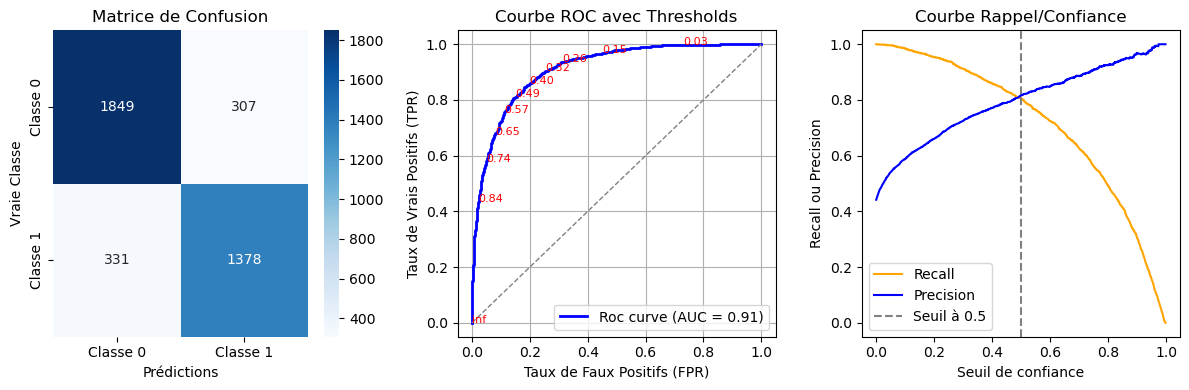

### Rapport de classification [Status.RETIRED] : 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88      1330
           1       0.83      0.81      0.82       908

    accuracy                           0.86      2238
   macro avg       0.85      0.85      0.85      2238
weighted avg       0.86      0.86      0.86      2238



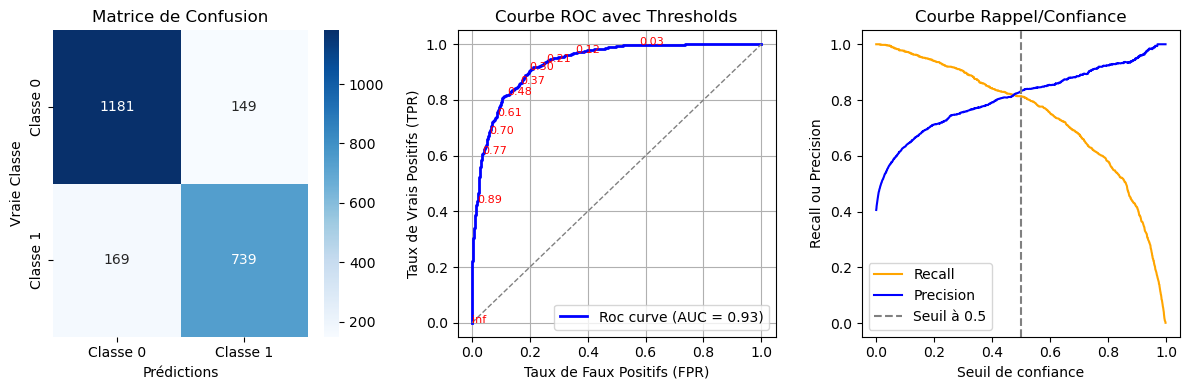

### Rapport de classification [Status.INACTIVE] : 
               precision    recall  f1-score   support

           0       0.89      0.93      0.91      2870
           1       0.78      0.67      0.72      1036

    accuracy                           0.86      3906
   macro avg       0.83      0.80      0.81      3906
weighted avg       0.86      0.86      0.86      3906



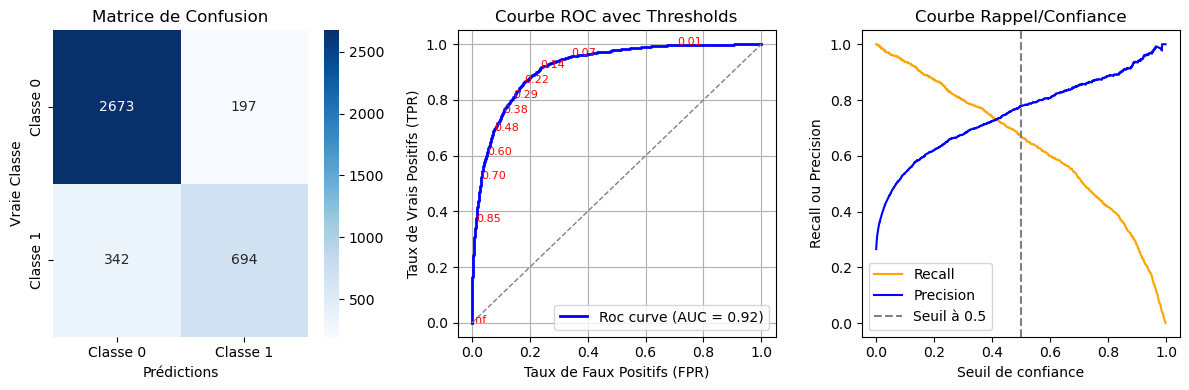

In [161]:
for data_proc in [active, retired, inactive]:
    evaluate_model(data_proc, "xgboost")

### Rapport de classification [All data_procs] : 
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      6356
           1       0.81      0.77      0.79      3653

    accuracy                           0.85     10009
   macro avg       0.84      0.83      0.84     10009
weighted avg       0.85      0.85      0.85     10009



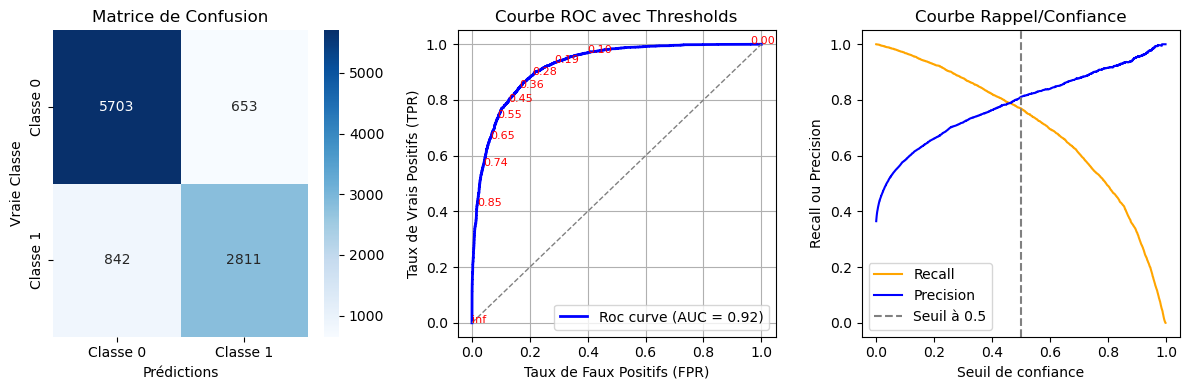

In [162]:
evaluate_multi_model([active, retired, inactive], "xgboost")

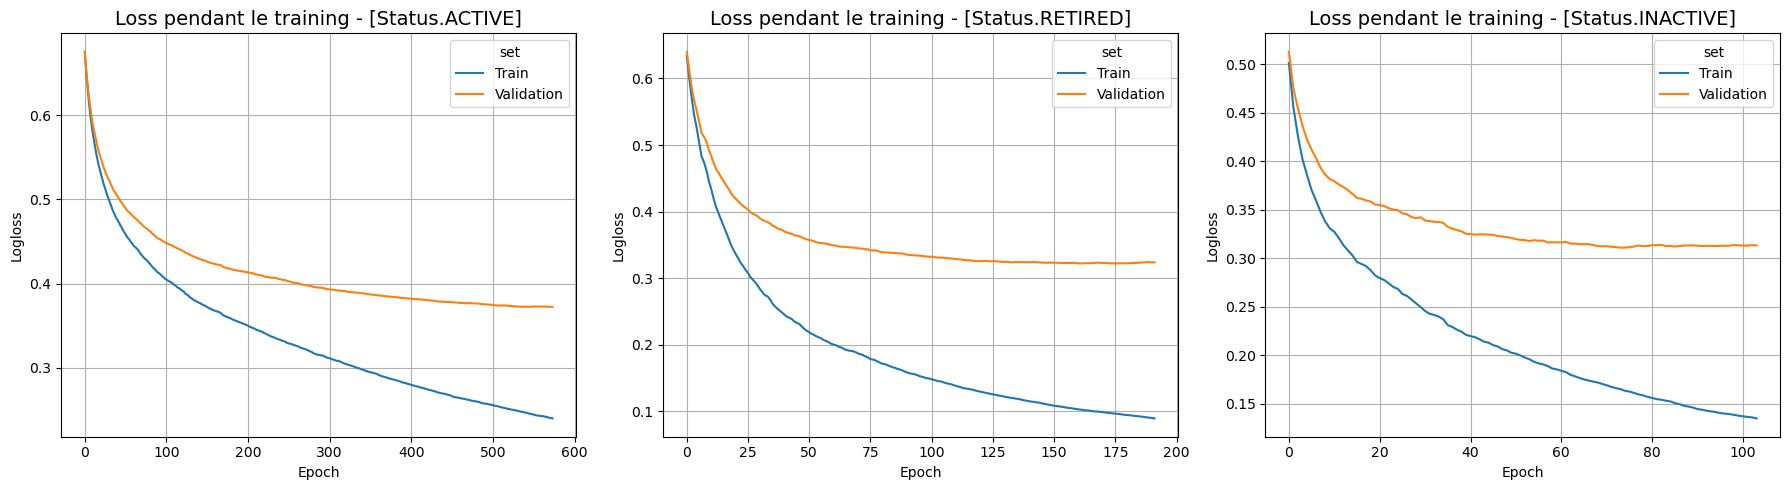

In [170]:
plot_loss([active, retired, inactive], "xgboost")

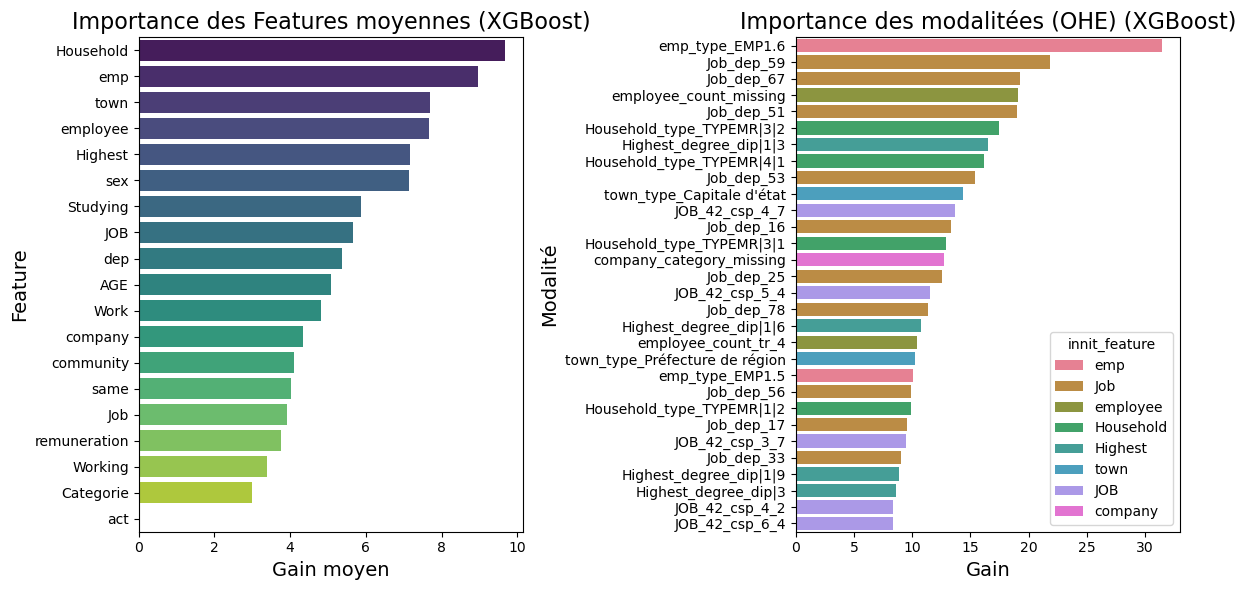

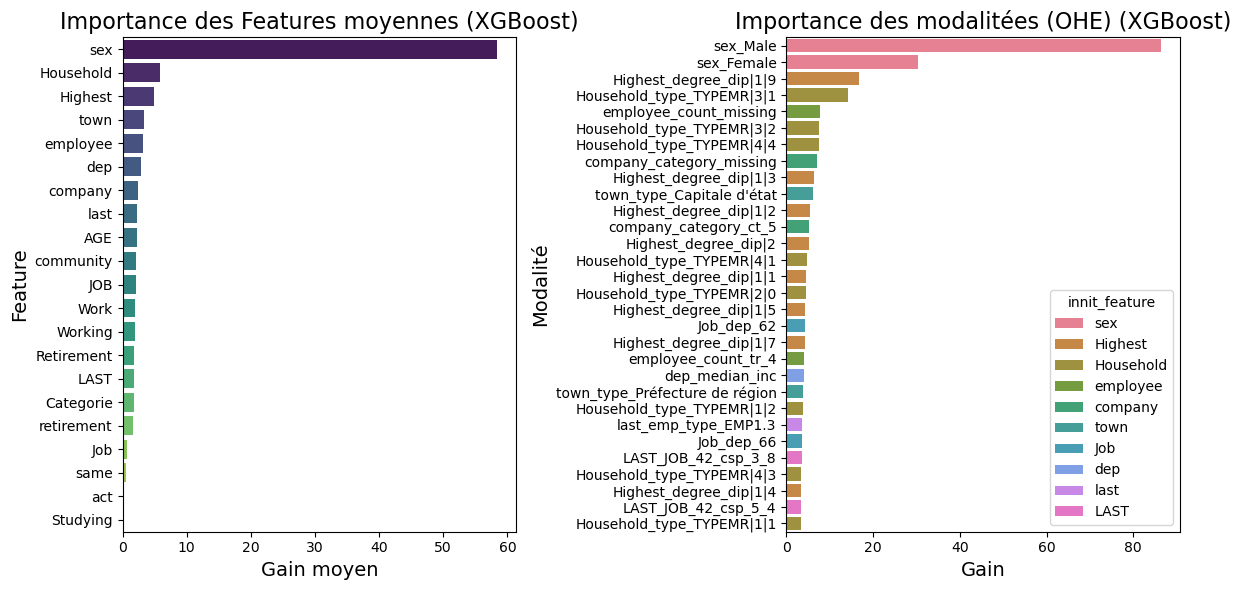

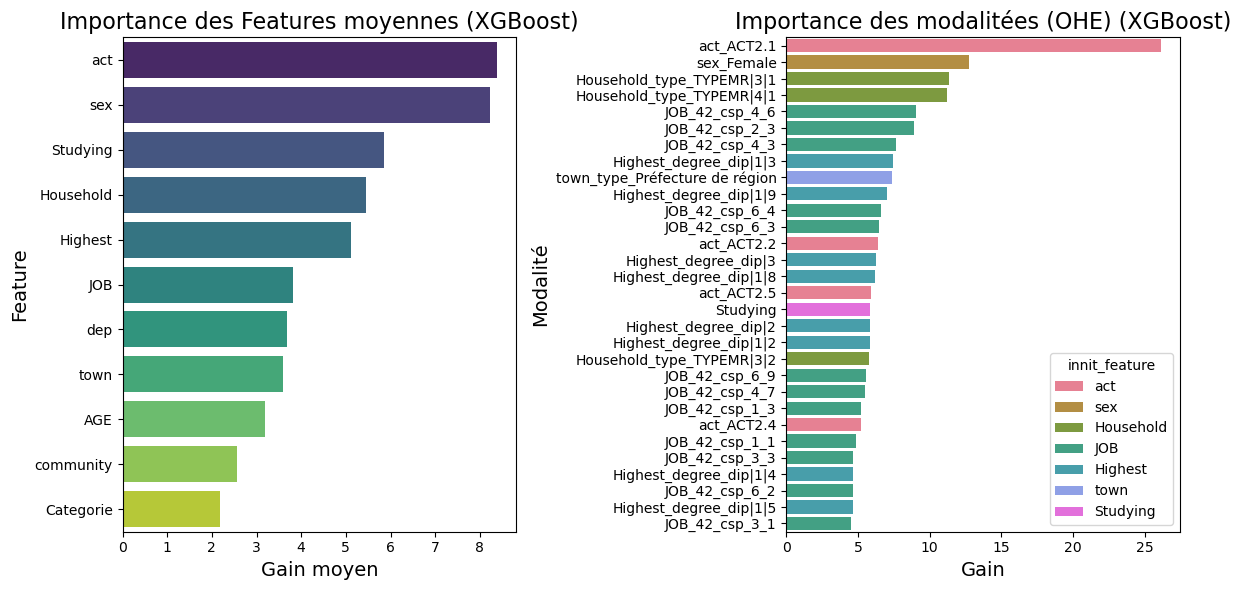

In [206]:
for data_proc in [active, retired, inactive]:
    plot_importance_xgb(data_proc)

In [ ]:
importance_df

In [73]:
summarize_categoricals(active.df, show_levels=True)

,Levels,No. of Levels,No. of Missing Values,% empty,type
Household_type,"[TYPEMR|4|1, TYPEMR|4|3, TYPEMR|1|2, TYPEMR|4|...",9,0,0.0,object
JOB_42,"[csp_5_4, csp_6_7, csp_5_3, csp_4_3, csp_5_5, ...",24,0,0.0,object
Highest_degree,"[dip|1|6, dip|1|3, dip|1|2, dip|1|7, dip|3, di...",12,0,0.0,object
Studying,"[0, 1]",2,0,0.0,int64
AGE_2019,"[46, 33, 24, 23, 43, 30, 59, 45, 56, 31, 53, 4...",61,0,0.0,int64
act,[ACT1.1],1,0,0.0,object
sex,"[Female, Male]",2,0,0.0,object
target,"['A', 'E'] Categories (2, object): ['A', 'E']",2,0,0.0,category
Working_hours,"[1935.0, 1697.0, nan, 1852.0, 1912.0, 1130.0, ...",2257,12,0.1,float64
company_category,"[ct_8, ct_9, ct_1, ct_3, ct_2, nan, ct_6, ct_7...",10,676,3.5,object


In [119]:
evals_result = {}

dtrain = xgb.DMatrix(active.X_train, label=active.y_train)
dvalid = xgb.DMatrix(active.X_valid, label=active.y_valid)

params = {'eval_metric': 'logloss','lambda': 1.8058050302270188e-05, 'alpha': 0.0006299004930996855, 'subsample': 0.7232472684178213, 'colsample_bytree': 0.831089108021323, 'max_depth': 11, 'min_child_weight': 8, 'eta': 0.08145387414628907, 'gamma': 0.8370126554624683, 'grow_policy': 'lossguide'}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dtrain, 'train'), (dvalid, 'validation')],
    evals_result=evals_result,
    verbose_eval=False
)

In [137]:
inactive_cb.evals_results["catboost"]['validation']['Logloss'][-20:]

[0.32888535142683545,
 0.3290813575962726,
 0.32920262147334844,
 0.32921990056686457,
 0.3291955469699971,
 0.3291579933031457,
 0.32912934219852996,
 0.32900498124629673,
 0.3289171973528241,
 0.3292279962660981,
 0.3292513412560345,
 0.32909752999060815,
 0.3291059956877928,
 0.3291691946095485,
 0.3292041623120182,
 0.3292477642615797,
 0.3291049397660053,
 0.3291201027844782,
 0.3290959447090726,
 0.32917672998205794]

In [136]:
inactive_cb.evals_results["catboost"]['learn']['Logloss'][-20:]

[0.13534923914601224,
 0.13475877804811495,
 0.13454236509912518,
 0.13431713413080035,
 0.13413541457070421,
 0.13398905080958473,
 0.13376274034657876,
 0.13353818921306243,
 0.13334155075098508,
 0.13306630836521652,
 0.13283506167706072,
 0.1324410277936039,
 0.13224765176330097,
 0.13177458935532912,
 0.13157658653121715,
 0.13121678355460054,
 0.13082607124755918,
 0.13057996181774842,
 0.13018276185940825,
 0.12982371407308615]

In [ ]:

pd.DataFrame(optimizer.cv_results_).sort_values(by="rank_test_neg_root_mean_squared_error").transpose()


,4,5,6,7,1,0,2,3
mean_fit_time,9.22224,8.39978,6.208585,6.195654,3.441637,3.653753,2.925943,2.925906
std_fit_time,0.070264,0.120468,0.067955,0.065964,0.082111,0.062149,0.032785,0.042493
mean_score_time,0.153986,0.165738,0.200285,0.1817,0.159284,0.181065,0.156455,0.172471
std_score_time,0.004257,0.00138,0.005449,0.01211,0.003448,0.000829,0.004225,0.003973
param_model__learning_rate,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
param_model__max_depth,20,20,20,20,10,10,10,10
param_model__max_features,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt
param_model__min_samples_leaf,2,2,5,5,2,2,5,5
param_model__min_samples_split,5,10,5,10,10,5,5,10
param_model__n_estimators,100,100,100,100,100,100,100,100


### Démarche de tuning d'hyper parametres avez gridSearch :


A Chaques experiences, on rédige un jeu de paramètres à tester, et on déduit lesquels garder en fonction du CV_results.

Si le produit cartésient (l'ensemble de combinaison) des paramètres est trop grand, on réduit le nombre de folds pour accélerer l'algo.

On choisit le paramètre étudié avec le meilleur score+std (on veux que les résultats entres folds ne varient peu pour garder une généralisation)

-> Process :

1. On commence par mettre tous les paramètres interessant et leurs des valeurs coherentes en vue du contexte. (Solver, pénalité, intercept, classes balancées...)

 - on execute un randomized, pour equarter les configurations evidantes.
 - on affine et décide de quels parametres garder

2. Pour les paramètres "importants" ici C, on effectue un GridSearch avec un jeu de paremètres restreits
   
 - sur des bornes larges, puis de plus en plus sérées



# Inférence

In [39]:
import pandas as pd

# Chargement des fichiers CSV
test_df = pd.read_csv("data/test_dataset.csv")
test_emp_type_df = pd.read_csv("data/test_dataset_emp_type.csv")
test_job_df = pd.read_csv("data/test_dataset_job.csv")
test_retired_former_df = pd.read_csv("data/test_dataset_retired_former.csv")
test_retired_jobs_df = pd.read_csv("data/test_dataset_retired_jobs.csv")
test_retired_pension_df = pd.read_csv("data/test_dataset_retired_pension.csv")
test_sport_df = pd.read_csv("data/test_dataset_sport.csv")

# Supposons que ces DataFrames sont définis quelque part dans ton code
# city_adm_df, city_pop_df, dep_median_inc_df, dep_act_rate_df, code_sports_df

def merge_add_dfs(df: pd.DataFrame) -> pd.DataFrame:
    df = df.merge(city_adm_df, on='INSEE', how='left')
    df = df.merge(city_pop_df, on='INSEE', how='left')
    df = df.merge(dep_median_inc_df, on='DEP', how='left')
    df = df.merge(test_sport_df, on='PRIMARY_KEY', how='left')
    df = df.merge(code_sports_df, left_on='sports', right_on='Code', how='left')
    try:
        df = df.merge(dep_act_rate_df, on='Job_dep', how='left')
    finally:
        return df

# Fusion des sous-données actives
test_active_subdf = test_job_df.merge(test_emp_type_df, on='PRIMARY_KEY', how='left')

# Fusion des sous-données retraitées
test_retired_subdf = test_retired_jobs_df \
    .merge(test_retired_former_df, on='PRIMARY_KEY', how='left') \
    .merge(test_retired_pension_df, on='PRIMARY_KEY', how='left')

# Dataset complet combiné
test_full_df = test_df.merge(pd.concat([test_active_subdf, test_retired_subdf]), on='PRIMARY_KEY', how='left')
test_full_df = merge_add_dfs(test_full_df)

# Subset actifs
test_active_df = test_df.merge(test_active_subdf, on='PRIMARY_KEY', how='inner')
test_active_df = merge_add_dfs(test_active_df)

# Subset retraités
test_retired_df = test_df.merge(test_retired_subdf, on='PRIMARY_KEY', how='inner')
test_retired_df = merge_add_dfs(test_retired_df)

# Subset inactifs
test_inactive_df = test_df[
    ~test_df['PRIMARY_KEY'].isin(test_active_df['PRIMARY_KEY']) &
    ~test_df['PRIMARY_KEY'].isin(test_retired_df['PRIMARY_KEY'])
]
test_inactive_df = merge_add_dfs(test_inactive_df)

# Vérification des tailles
assert test_full_df.shape[0] == test_active_df.shape[0] + test_retired_df.shape[0] + test_inactive_df.shape[0]

# Affichage
print(test_full_df.shape, test_active_df.shape, test_retired_df.shape, test_inactive_df.shape)


(50040, 36) (19202, 31) (11202, 34) (19636, 19)


In [59]:
full_df

,PRIMARY_KEY,INSEE,Household_type,JOB_42,Highest_degree,Studying,AGE_2019,act,sex,target,...,town_type,DEP,community_size,dep_median_inc,sports,Code,Categorie,Nom fédération,Nom catégorie,dep_act_rate
0,1,01002,TYPEMR|3|2,csp_8_4,dip|1|2,True,18,ACT2.2,Male,A,...,Commune simple,01,257,24810,NaN,NaN,NaN,NaN,NaN,NaN
1,6,01004,TYPEMR|1|1,csp_7_4,dip|1|9,False,75,ACT2.1,Male,A,...,Chef-lieu canton,01,14514,24810,NaN,NaN,NaN,NaN,NaN,79.4
2,9,01004,TYPEMR|4|1,csp_5_4,dip|1|6,False,46,ACT1.1,Female,A,...,Chef-lieu canton,01,14514,24810,NaN,NaN,NaN,NaN,NaN,79.1
3,11,01004,TYPEMR|4|1,csp_6_7,dip|1|3,False,33,ACT1.1,Male,E,...,Chef-lieu canton,01,14514,24810,NaN,NaN,NaN,NaN,NaN,79.1
4,14,01004,TYPEMR|4|1,csp_8_4,dip|3,True,18,ACT2.2,Male,E,...,Chef-lieu canton,01,14514,24810,CF-604,CF-604,6.0,Union nationale du sport scolaire (UNSS),Fédération multisports scolaire ou universitaire,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50037,100074,95680,TYPEMR|4|1,csp_4_6,dip|1|5,False,37,ACT1.1,Female,A,...,Chef-lieu canton,95,28540,23290,NaN,NaN,NaN,NaN,NaN,82.6
50038,100077,95680,TYPEMR|4|4,csp_7_8,dip|1|3,False,73,ACT2.1,Male,A,...,Chef-lieu canton,95,28540,23290,NaN,NaN,NaN,NaN,NaN,78.0
50039,100080,95680,TYPEMR|4|4,csp_7_5,dip|1|4,False,66,ACT2.1,Female,A,...,Chef-lieu canton,95,28540,23290,NaN,NaN,NaN,NaN,NaN,66.8
50040,100081,95680,TYPEMR|3|1,csp_8_1,dip|1|3,False,19,ACT1.2,Male,A,...,Chef-lieu canton,95,28540,23290,CF-604,CF-604,6.0,Union nationale du sport scolaire (UNSS),Fédération multisports scolaire ou universitaire,NaN


In [58]:
test_full_df

,PRIMARY_KEY,INSEE,Household_type,JOB_42,Highest_degree,Studying,AGE_2019,act,sex,Working_hours,...,town_type,DEP,community_size,dep_median_inc,sports,Code,Categorie,Nom fédération,Nom catégorie,dep_act_rate
0,2,01002,TYPEMR|4|3,csp_8_4,dip|3,True,18,ACT2.2,Male,NaN,...,Commune simple,01,257,24810,NaN,NaN,NaN,NaN,NaN,NaN
1,3,01004,TYPEMR|4|3,csp_8_5,dip|3,True,15,ACT2.2,Male,NaN,...,Chef-lieu canton,01,14514,24810,NaN,NaN,NaN,NaN,NaN,NaN
2,4,01004,TYPEMR|4|2,csp_8_5,dip|1|4,False,54,ACT2.4,Female,NaN,...,Chef-lieu canton,01,14514,24810,NaN,NaN,NaN,NaN,NaN,NaN
3,5,01004,TYPEMR|4|2,csp_6_8,dip|3,False,64,ACT1.1,Male,NaN,...,Chef-lieu canton,01,14514,24810,NaN,NaN,NaN,NaN,NaN,NaN
4,7,01004,TYPEMR|4|4,csp_7_7,dip|1|2,False,76,ACT2.1,Female,1854.0,...,Chef-lieu canton,01,14514,24810,NaN,NaN,NaN,NaN,NaN,84.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50035,100071,95680,TYPEMR|4|2,csp_8_5,dip|1|3,False,38,ACT2.5,Female,NaN,...,Chef-lieu canton,95,28540,23290,NaN,NaN,NaN,NaN,NaN,NaN
50036,100075,95680,TYPEMR|4|1,csp_5_2,dip|1|3,False,63,ACT1.1,Female,1823.0,...,Chef-lieu canton,95,28540,23290,NaN,NaN,NaN,NaN,NaN,86.9
50037,100076,95680,TYPEMR|4|3,csp_3_8,dip|1|8,False,25,ACT1.1,Female,1683.0,...,Chef-lieu canton,95,28540,23290,NaN,NaN,NaN,NaN,NaN,92.4
50038,100078,95680,TYPEMR|3|1,csp_8_5,dip|3,False,29,ACT2.5,Male,NaN,...,Chef-lieu canton,95,28540,23290,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def get_threshold(status: Status):
    optimum_thresholds = {
        Status.ACTIVE: 0.5,
        Status.RETIRED: 0.5,
        Status.INACTIVE: 0.38,
    }
    return optimum_thresholds.get(status, 0.5)

def predict_pipeline(data_proc:DataPreprocessor, df: pd.DataFrame) -> pd.DataFrame:
    inference_df = df.copy()
    inference_df = inference_df.drop("target", axis=1, errors="ignore")
    inference_df = data_proc.add_features(inference_df)
    inference_df = data_proc.preprocess_columns(inference_df, inference=True)
    inference_df = data_proc.encoder_transform(inference_df)
    
    y_proba = data_proc.models["xgboost"].predict(xgb.DMatrix(inference_df))
    y_preds = (y_proba > get_threshold(data_proc.status)).astype(int)
    y_preds = data_proc.target_encoder_inverse_transform(y_preds)

    result_df = pd.DataFrame(y_preds, index=df["PRIMARY_KEY"], columns=["target"])
    return result_df


In [60]:
# Concaténation des prédictions pour chaque groupe
df_final = pd.concat(
    list(map(
        lambda data_proc, inference_df: predict_pipeline(data_proc, inference_df),
        [active, retired, inactive], [test_active_df, test_retired_df, test_inactive_df]
    ))
).sort_index()

# Sauvegarde du fichier résultat
df_final.to_csv("result_v1.csv", sep=",", index="PRIMARY_KEY")

In [61]:
df_final

,target
PRIMARY_KEY,
2,A
3,E
4,A
5,E
7,A
...,...
100071,A
100075,E
100076,A
